# Deep Learning Bootcamp - Final Data Challenge

As the final task of this bootcamp, the goal was to explore three different approaches to classify images of dogs and cats respectively. All of the deep learning models were done in **tensorflow.keras**.
For this project the chosen approaches were:
* CNN
* Transfer Learning with Xception based on the weights of ImageNet
* Transfer Learning with ResNet 50

In the following chapters each aproach will be further explained and the results will be evaluated.

At the start of the notebook, all the necessary imports are listed and then the datasets will be explored in order check if the dataset is balanced or not.

## Imports

In [1]:
## OS
import os

## Import json
import json

## Standard imports
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import time

## Tensorflow and Keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.layers import LeakyReLU

## Set up of the dimensions of the images

The set up image dimensions are 128 pixels high and wide. Also there are three color channels. The color channels are red, blue and green.

In [2]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

## Set up paths

In [4]:
trainings_path = "raw_data/training_data"
test_path = "raw_data/validation_data"
validation_path = "raw_data/validation_data"

## Directory to the the training_data

The data was previously divided by our teacher Dr. Claus Horn into a training and a validation data set. There are no further folder structures within the data sets. Therefore, the pictures are divided into the classes dogs and cats based on the picture name. After the split into the classes, the sizes will be compared 

In [5]:
filenames=os.listdir(trainings_path)
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df_training_data=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [6]:
df_training_data.head()

,filename,category
0,dog.7444.jpg,1
1,dog.11670.jpg,1
2,cat.1563.jpg,0
3,cat.1205.jpg,0
4,dog.8005.jpg,1


In [7]:
filenames=os.listdir(trainings_path)
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append("Dog")
    else:
        categories.append("Cat")
df_training_data_histogram=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In the graph below we can see, that the training data set is pretty balanced.

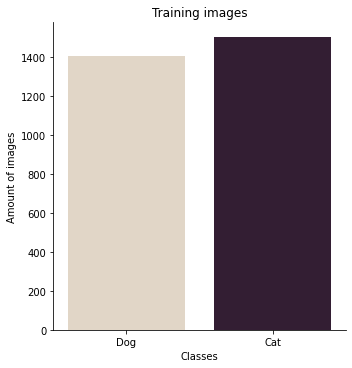

In [8]:
sns.catplot(x="category", kind="count", palette="ch:.25", data=df_training_data_histogram)
plt.xlabel('category')
plt.title("Training images")
plt.xlabel("Classes")
plt.ylabel("Amount of images")
plt.show()

In [9]:
filenames=os.listdir(test_path)
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df_validation_data=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [10]:
df_validation_data.head()

,filename,category
0,cat.12020.jpg,0
1,dog.991.jpg,1
2,cat.9671.jpg,0
3,dog.9333.jpg,1
4,dog.4171.jpg,1


In [11]:
filenames=os.listdir(test_path)
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append("Dog")
    else:
        categories.append("Cat")
df_validation_data_histogram=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

The same can be said for the validation data set.

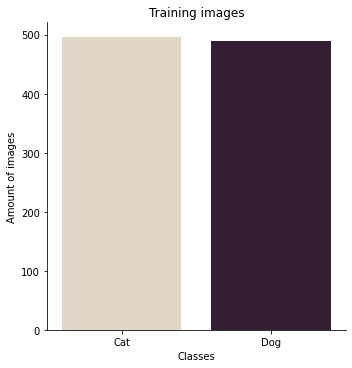

In [12]:
sns.catplot(x="category", kind="count", palette="ch:.25", data=df_validation_data_histogram)
plt.xlabel('category')
plt.title("Training images")
plt.xlabel("Classes")
plt.ylabel("Amount of images")
plt.show()

After the exploration of the datasets we can see, that the it is balanced and with that we can continue with getting the first model, to get a better understand of what could work and what not.

# CNN

The first experiment is executed with a CNN. This method has shown to be a good solution when dealing with images.

At the beginning we did just start out with a random model and did not augment the images before they were fed to the model. As can be seen further down, after the training of the model, the validation loss is more or less exploding after the tenth epochs.

In code cell below can be seen that the data from the training set, which was already set up, is split into training and validation sets.

The split ration is 80% training (2325 images) and 20% validation (582 images) and a batch size of 15 is defined. 

In [13]:
df_training_data["category"] = df_training_data["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df_training_data,test_size=0.20,random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]

In [14]:
batch_size=15

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 trainings_path,x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='binary',
                                                 batch_size=batch_size)

Found 2325 validated image filenames belonging to 2 classes.


In [16]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    trainings_path, 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='binary',
    batch_size=batch_size)

Found 582 validated image filenames belonging to 2 classes.


What was initially labeled as validation data set, is now used as a test set. This was made so there was no further coding set needed.

In [17]:
df_validation_data["category"] = df_validation_data["category"].replace({0:'cat',1:'dog'})
test_df = df_validation_data
test_df = test_df.reset_index(drop=True)
total_test = test_df.shape[0]

In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                 trainings_path,x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='binary',
                                                 batch_size=batch_size)

Found 65 validated image filenames belonging to 2 classes.


/Users/Bernardo/opt/anaconda3/envs/vision/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 920 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(Image_Width,Image_Height, Image_Channels)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

2022-02-26 17:00:35.850174: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [22]:
epochs=20
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/20
155/155 [==============================] - 36s 224ms/step - loss: 0.6948 - accuracy: 0.5054 - val_loss: 0.6911 - val_accuracy: 0.5246
Epoch 2/20
155/155 [==============================] - 35s 224ms/step - loss: 0.6902 - accuracy: 0.5256 - val_loss: 0.6957 - val_accuracy: 0.5228
Epoch 3/20
155/155 [==============================] - 32s 203ms/step - loss: 0.6836 - accuracy: 0.5497 - val_loss: 0.6827 - val_accuracy: 0.5649
Epoch 4/20
155/155 [==============================] - 30s 192ms/step - loss: 0.6674 - accuracy: 0.6060 - val_loss: 0.6792 - val_accuracy: 0.5526
Epoch 5/20
155/155 [==============================] - 33s 211ms/step - loss: 0.6318 - accuracy: 0.6378 - val_loss: 0.6421 - val_accuracy: 0.6404
Epoch 6/20
155/155 [==============================] - 38s 242ms/step - loss: 0.6022 - accuracy: 0.6611 - val_loss: 0.6391 - val_accuracy: 0.6421
Epoch 7/20
155/155 [==============================] - 33s 211ms/step - loss: 0.5785 - accuracy: 0.6856 - val_loss: 0.6084 - val_ac

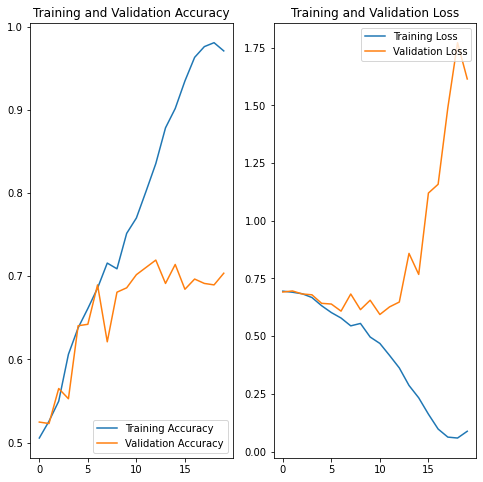

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

So it can be stated, that the first random guess did not work out. Because of that different adjustments were made. The training data will be augmented and the learning rate will be adjusted while training the model. The results look more promising. More details about the model can be seen below.

## Base model

In the model below worked as a baseline. First it was the goal to see if a achrchitecture, which worked previously in a different project, also for this one. It consists of one input layer, three hidden layers and one output layer. Each hidden layer and also the input layer use the ReLU activation function and MaxPooling. Also does each layer have a filter with the dimensions of 3 by 3. The neurons per layer increase from 32 to 128. At the end the values are flattened, so that the dense layers can be used. The first dense layer also uses a ReLU activation function. The last one uses a sigmoid function and consists of one neuron. With this the binary classification can be done.

Also as already mentioned that training data is augmented.

The model is then compiled with a binary crossentropy to calculate the loss and uses the adam optimizer. This optimizer has shown to be a good default choice.

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(Image_Width,Image_Height,Image_Channels)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Below a summary of the first CNN can be seen.

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 128)     

Additionally to the explanation of the model before, below there are several things defined, while the model is trained. *Earlystop* is used, that if the model, does no improve over 10 epochs the training should stop. Additionally the *learning rate reduction* is used to adjust the learning rate, when the loss of the validation data does not improve. Once it does not improve for three or more epochs the learningrate will be multiplied by 0.5 and with that decreased.

In [26]:
earlystop = EarlyStopping(patience = 10, monitor="val_loss")
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

There the data from the default folder *training_data* is split into training and validation data frames. Also the batch size is defined to batch size is defined to 15.

## Data Augmentation

In those code cells the images for the training data is augmented. That means that the images are rescaled, zoomed in on, horizontally flimed and more. This should help to prevent over fitting, because the model has to incorpore many different variations and is foreced to generalized.

In [27]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 trainings_path,x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='binary',
                                                 batch_size=batch_size)

Found 2325 validated image filenames belonging to 2 classes.


In [28]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Below the images show how they are augmented.

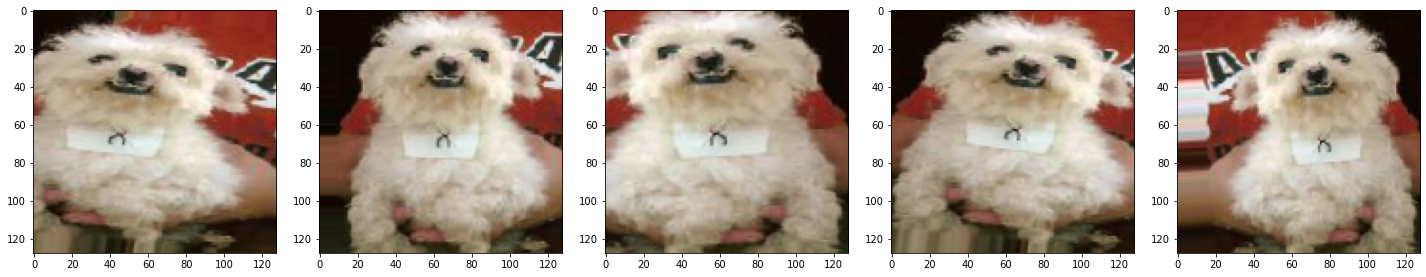

In [29]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

The validation data is simply rescaled, but not further augmented.

In [30]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    trainings_path, 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='binary',
    batch_size=batch_size
)

Found 582 validated image filenames belonging to 2 classes.


In [31]:
df_validation_data["category"] = df_validation_data["category"].replace({0:'cat',1:'dog'})
test_df = df_validation_data
test_df = test_df.reset_index(drop=True)
total_test = test_df.shape[0]
batch_size=15

For the test data the images from the validation data is used.

In [32]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                 trainings_path,x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='binary',
                                                 batch_size=batch_size,
                                                  shuffle=True)

Found 65 validated image filenames belonging to 2 classes.


Here the base model is trained for 20 epochs

In [33]:
epochs=20
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
155/155 [==============================] - 32s 204ms/step - loss: 0.6963 - accuracy: 0.5161 - val_loss: 0.6927 - val_accuracy: 0.5281 - lr: 0.0010
Epoch 2/20
155/155 [==============================] - 32s 204ms/step - loss: 0.6925 - accuracy: 0.5148 - val_loss: 0.6872 - val_accuracy: 0.5263 - lr: 0.0010
Epoch 3/20
155/155 [==============================] - 32s 206ms/step - loss: 0.6891 - accuracy: 0.5312 - val_loss: 0.6847 - val_accuracy: 0.5281 - lr: 0.0010
Epoch 4/20
155/155 [==============================] - 32s 209ms/step - loss: 0.6841 - accuracy: 0.5544 - val_loss: 0.6925 - val_accuracy: 0.4947 - lr: 0.0010
Epoch 5/20
155/155 [==============================] - 32s 207ms/step - loss: 0.6819 - accuracy: 0.5505 - val_loss: 0.6856 - val_accuracy: 0.5456 - lr: 0.0010
Epoch 6/20
155/155 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.5454
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
155/155 [=========================

As we can see in the plots below the accuracy on the training and validation data increases steadily and the loss also decreases with more and more iterations. But the learning rate was automatically adjusted during the training of the model.

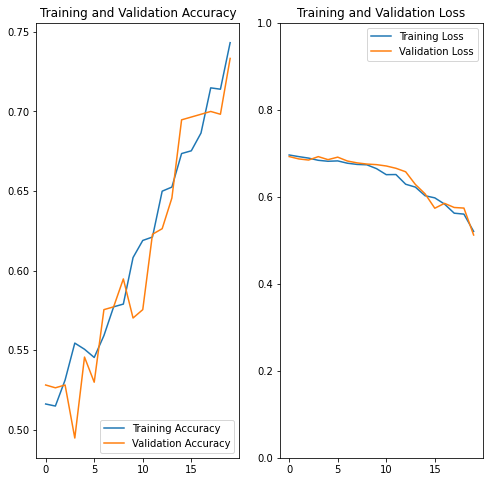

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
ax = plt.gca()
ax.set_ylim([0, 1])
plt.show()

Below the model will be saved.

In [35]:
model.save("models/base_line_catsVSdogs_20epoch.h5")

In [36]:
test_filenames = os.listdir(test_path)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [37]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

The base model achieves an accuracy of 76.95% on the training data. In the following parts of the notebook, the goal is to improve on that, but the chosen architecture works as a good first set up.

In [38]:
predict_evaluate = model.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size))

66/66 [==============================] - 0s 3ms/step - loss: 0.4709 - accuracy: 0.7692


## Multiple models

In this chapter there are multiple architectures examinated. Below can be seen that different amount of neurons and hidden layers are looked at.

In [39]:
layer_sizes = [64,128,256] #
conv_layers = [2,3,4]

In [40]:
import datetime 
dt = datetime.datetime.now()

In [41]:
for layer_size in layer_sizes:
    for conv_layer in conv_layers:

        NAME = "{}-conv-{}-nodes-{}".format(conv_layer, layer_size, int(dt.strftime("%Y%m%d%H%M%S")))
        #tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
        print(NAME)

2-conv-64-nodes-20220226172309
3-conv-64-nodes-20220226172309
4-conv-64-nodes-20220226172309
2-conv-128-nodes-20220226172309
3-conv-128-nodes-20220226172309
4-conv-128-nodes-20220226172309
2-conv-256-nodes-20220226172309
3-conv-256-nodes-20220226172309
4-conv-256-nodes-20220226172309


There reason why the focus lies on the layer size and amount of hidden layers is, that all the models need a lot of time to run. There would have been other things to try, but due to limited computational power it was decided to mainly focus on the architecture.

In [42]:
for layer_size in layer_sizes:
    for conv_layer in conv_layers:

        NAME = "{}-conv-{}-nodes-{}".format(conv_layer, layer_size, int(dt.strftime("%Y%m%d%H%M%S")))
        tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
        earlystop = EarlyStopping(patience = 10, monitor="val_loss")
        learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.5,min_lr = 0.00001)
        callbacks = [earlystop,learning_rate_reduction, tensorboard]
        print(NAME)

        model = Sequential()
        model.add(Conv2D(32, (3,3), activation='relu', input_shape=(Image_Width,Image_Height,Image_Channels)))
        model.add(MaxPooling2D(2,2))

        for l in range(conv_layer-1):
            model.add(Conv2D(layer_size, (3,3), activation='relu'))
            model.add(MaxPooling2D(2,2))

        model.add(Flatten())

        model.add(Dense(256))
        model.add(Activation("relu"))

        model.add(Dense(1))
        model.add(Activation("sigmoid"))


        model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
        
        
        
        epochs=20
        history = model.fit(
            train_generator, 
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=total_validate//batch_size,
            steps_per_epoch=total_train//batch_size,
            callbacks=callbacks)
        
        model.save("models/" + NAME + ".h5")
        predict_evaluate = model.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size))

2-conv-64-nodes-20220226172309
Epoch 1/20
155/155 [==============================] - 38s 239ms/step - loss: 0.7716 - accuracy: 0.5535 - val_loss: 0.6993 - val_accuracy: 0.5439 - lr: 0.0010
Epoch 2/20
155/155 [==============================] - 36s 229ms/step - loss: 0.6771 - accuracy: 0.5712 - val_loss: 0.6765 - val_accuracy: 0.6018 - lr: 0.0010
Epoch 3/20
155/155 [==============================] - 36s 231ms/step - loss: 0.6532 - accuracy: 0.6245 - val_loss: 0.6469 - val_accuracy: 0.6351 - lr: 0.0010
Epoch 4/20
155/155 [==============================] - 31s 203ms/step - loss: 0.6575 - accuracy: 0.6108 - val_loss: 0.6485 - val_accuracy: 0.6509 - lr: 0.0010
Epoch 5/20
155/155 [==============================] - 32s 207ms/step - loss: 0.6393 - accuracy: 0.6219 - val_loss: 0.6238 - val_accuracy: 0.6596 - lr: 0.0010
Epoch 6/20
155/155 [==============================] - 33s 213ms/step - loss: 0.6177 - accuracy: 0.6568 - val_loss: 0.6160 - val_accuracy: 0.6614 - lr: 0.0010
Epoch 7/20
155/155 [=

All of the models are saved and also tensorboard was used to compare the accuracy and loss decreas of the different models.
Below all of the models are loaded and there accuracy is tested.

In [48]:
_2_conv_64_nodes_20220219112148 = tf.keras.models.load_model('models/2-conv-64-nodes-20220226172309.h5')
_3_conv_64_nodes_20220219112148 = tf.keras.models.load_model('models/3-conv-64-nodes-20220226172309.h5')
_4_conv_64_nodes_20220219112148 = tf.keras.models.load_model('models/4-conv-64-nodes-20220226172309.h5')
_2_conv_128_nodes_20220219112148 = tf.keras.models.load_model('models/2-conv-128-nodes-20220226172309.h5')
_3_conv_128_nodes_20220219112148 = tf.keras.models.load_model('models/3-conv-128-nodes-20220226172309.h5')
_4_conv_128_nodes_20220219112148 = tf.keras.models.load_model('models/4-conv-128-nodes-20220226172309.h5')
_2_conv_256_nodes_20220219112148 = tf.keras.models.load_model('models/2-conv-256-nodes-20220226172309.h5')
_3_conv_256_nodes_20220219112148 = tf.keras.models.load_model('models/3-conv-256-nodes-20220226172309.h5')
_4_conv_256_nodes_20220219112148 = tf.keras.models.load_model('models/4-conv-256-nodes-20220226172309.h5')

In [49]:
_2_conv_64_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size))

66/66 [==============================] - 0s 3ms/step - loss: 0.6031 - accuracy: 0.7231


[0.6031317114830017, 0.7230769395828247]

In [ ]:
print("_3_conv_64_nodes_20220226172309" ,_3_conv_64_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size))) 
print("_4_conv_64_nodes_20220226172309" ,_4_conv_64_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size))) 
print("_2_conv_128_nodes_20220226172309",_2_conv_128_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size)))
print("_3_conv_128_nodes_20220226172309",_3_conv_128_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size)))
print("_4_conv_128_nodes_20220226172309",_4_conv_128_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size)))
print("_2_conv_256_nodes_20220226172309",_2_conv_256_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size)))
print("_3_conv_256_nodes_20220226172309",_3_conv_256_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size)))
print("_4_conv_256_nodes_20220226172309",_4_conv_256_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size)))

66/66 [==============================] - 0s 3ms/step - loss: 0.4552 - accuracy: 0.7692
_3_conv_64_nodes_20220219112148 [0.45521801710128784, 0.7692307829856873]
66/66 [==============================] - 1s 2ms/step - loss: 0.4798 - accuracy: 0.7846
_4_conv_64_nodes_20220219112148 [0.4798007607460022, 0.7846153974533081]
66/66 [==============================] - 0s 3ms/step - loss: 0.4226 - accuracy: 0.8000
_2_conv_128_nodes_20220219112148 [0.42264166474342346, 0.800000011920929]
66/66 [==============================] - 1s 5ms/step - loss: 0.6105 - accuracy: 0.6615
_3_conv_128_nodes_20220219112148 [0.6104866862297058, 0.6615384817123413]
66/66 [==============================] - 0s 4ms/step - loss: 0.4979 - accuracy: 0.8000
_4_conv_128_nodes_20220219112148 [0.49785149097442627, 0.800000011920929]
66/66 [==============================] - 1s 5ms/step - loss: 0.4648 - accuracy: 0.8154
_2_conv_256_nodes_20220219112148 [0.4647676348686218, 0.8153846263885498]
66/66 [============================

In [ ]:
_2_conv_128_nodes_20220219112148.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 61, 61, 128)       36992     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 30, 30, 128)      0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 115200)            0         
                                                                 
 dense_10 (Dense)            (None, 256)              

The best architecture seems to be with one hidden layers and 128 neurons. This is now further developed. Now there is a random guess with adding dropout and batch normalization for each layer.

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
arlystop = EarlyStopping(patience = 10, monitor="val_loss")
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.5,min_lr = 0.00001)
NAME = "2_conv_128_nodes-Batchnorm-Dropout-{}".format(int(dt.strftime("%Y%m%d%H%M%S")))
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
callbacks = [earlystop,learning_rate_reduction, tensorboard]

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 61, 61, 128)       36992     
                                                                 
 batch_normalization (BatchN  (None, 61, 61, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 30, 30, 128)      0         
 g2D)                                                            
                                                     

The model will now be trained longer, to get maybe a better result.

In [55]:
epochs=30
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)

Epoch 1/30
155/155 [==============================] - 61s 391ms/step - loss: 0.9160 - accuracy: 0.5527 - val_loss: 0.6785 - val_accuracy: 0.5842 - lr: 0.0010
Epoch 2/30
155/155 [==============================] - 59s 379ms/step - loss: 0.7995 - accuracy: 0.5880 - val_loss: 0.7020 - val_accuracy: 0.5263 - lr: 0.0010
Epoch 3/30
155/155 [==============================] - 60s 387ms/step - loss: 0.7131 - accuracy: 0.6112 - val_loss: 0.6530 - val_accuracy: 0.6140 - lr: 0.0010
Epoch 4/30
155/155 [==============================] - 56s 359ms/step - loss: 0.6928 - accuracy: 0.6103 - val_loss: 0.7239 - val_accuracy: 0.6228 - lr: 0.0010
Epoch 5/30
155/155 [==============================] - 55s 356ms/step - loss: 0.6615 - accuracy: 0.6301 - val_loss: 0.7530 - val_accuracy: 0.5509 - lr: 0.0010
Epoch 6/30
155/155 [==============================] - ETA: 0s - loss: 0.6400 - accuracy: 0.6288
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
155/155 [=========================

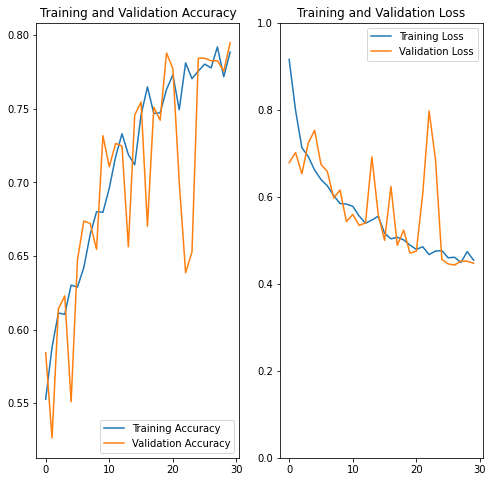

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
ax = plt.gca()
ax.set_ylim([0, 1])
plt.show()

In [57]:
model.save("models/" + NAME + ".h5")

In [58]:
model.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size))

66/66 [==============================] - 0s 4ms/step - loss: 0.4452 - accuracy: 0.8154


[0.44519540667533875, 0.8153846263885498]

The accuracy of the model stayed almost the same with 76.95% compared to the model without dropout and batch normalization.

In [60]:
model_with_dropout_batchnorm = tf.keras.models.load_model("models/2_conv_128_nodes-Batchnorm-Dropout-20220226172309.h5")

# Transfer learning

After the exploration of a own deep learning model, the second aproach is transfer learning. Here a pre-trained model will be used and then based on that the images classified of our own data set. Xception is used for this task here.

In [61]:
base_model = tf.keras.applications.Xception(
            weights = "imagenet", ## load weights pre-trained on ImageNet
            input_shape = (Image_Width,Image_Height,Image_Channels),
            include_top=False
            )

83697664/83683744 [==============================] - 652s 8us/step


## Freeze the base_model

First the layers are freezed and will not be updated during the training.

In [62]:
base_model.trainable = False

In [63]:
inputs = tf.keras.Input(shape=(Image_Width,Image_Height,Image_Channels))

The weights of Xception (pre-trained) need to be normalized.

In [64]:
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()

In [65]:
mean = np.array([127.5]*3)
var = mean ** 2

In [66]:
## Scale the input

In [67]:
x = norm_layer(inputs)
#norm_layer.set_weights([mean, var])

In [68]:
from numpy import sqrt
norm_layer = (inputs - mean) / sqrt(var)

In [69]:
norm_layer

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'tf.math.truediv')>

In [70]:
x = base_model(x, training=False)

In [71]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x) # regularize with dropout
outputs = tf.keras.layers.Dense(1)(x)

In [72]:
model = tf.keras.Model(inputs, outputs)

In [73]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 normalization (Normalizatio  (None, 128, 128, 3)      7         
 n)                                                              
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 1)                 2049  

In [74]:
model.compile(optimizer="adam", loss = "binary_crossentropy", metrics=["accuracy"])

In [75]:
epochs = 3

Here we can see, that the model did have a better accuracy, but the validation loss increased after the second epoch.

In [76]:
model.fit(train_generator, epochs=epochs, validation_data = validation_generator)

Epoch 1/3
155/155 [==============================] - 69s 433ms/step - loss: 1.8146 - accuracy: 0.8219 - val_loss: 1.2485 - val_accuracy: 0.8832
Epoch 2/3
155/155 [==============================] - 65s 420ms/step - loss: 2.0462 - accuracy: 0.8275 - val_loss: 1.1161 - val_accuracy: 0.8935
Epoch 3/3
155/155 [==============================] - 66s 424ms/step - loss: 1.0815 - accuracy: 0.8890 - val_loss: 1.1744 - val_accuracy: 0.9003


## Unfreeze the base_model

Here the layers will be updated during the training.

In [77]:
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 normalization (Normalizatio  (None, 128, 128, 3)      7         
 n)                                                              
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 1)                 2049  

The loss is set up according to the suggestion of the tensorflow documentation. With *from_logits=True* the model's prediction, i.e, a single floating-point which represents a value from [- infinity to infinity].

In [78]:
model.compile(
optimizer = tf.keras.optimizers.Adam(1e-5),
            loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
metrics=[tf.keras.metrics.BinaryAccuracy()],)

In [79]:
epochs = 2
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/2
155/155 [==============================] - 280s 2s/step - loss: 0.1580 - binary_accuracy: 0.9338 - val_loss: 0.1258 - val_binary_accuracy: 0.9553
Epoch 2/2
155/155 [==============================] - 280s 2s/step - loss: 0.1107 - binary_accuracy: 0.9596 - val_loss: 0.1167 - val_binary_accuracy: 0.9502


In [80]:
predictions = model.predict(test_generator)

In [81]:
#predictions

In [82]:
model.save("models/transfer_learning_trainables_true.h5")

/Users/Bernardo/opt/anaconda3/envs/vision/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [84]:
transfer_learning_trainables_true = tf.keras.models.load_model('models/transfer_learning_trainables_true.h5')

With transfer learning the model takes a long time to train, but the results are very good. This model perform with an accuracy of 94.42% and also the loss is very low, compared to the models before.

In [85]:
transfer_learning_trainables_true.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size))

66/66 [==============================] - 2s 17ms/step - loss: 0.1065 - binary_accuracy: 0.9385


[0.10652150958776474, 0.9384615421295166]

## Check out some predictions

Here we can see that the model precits many different kind of pictures correctly, even in one case, where also a girl is shown in the image, the classification is correct.

In [86]:
class_names = ["cat", "dog"]

Predictions:
 [0 1 0 0 1 0 1 1 1 0 1 1 1 0 1]
Labels:
 [0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.]


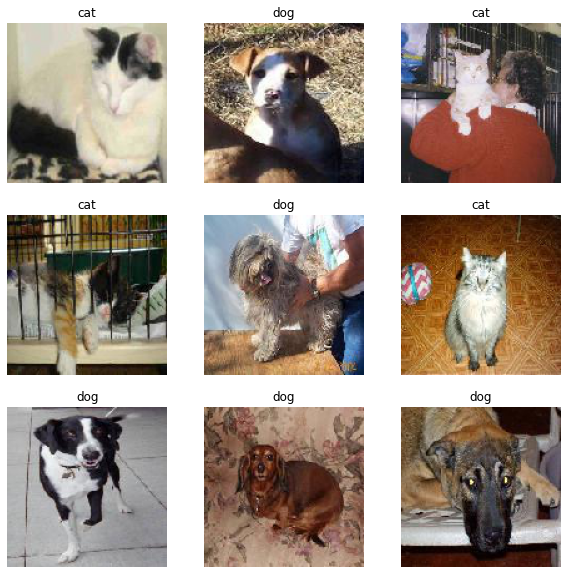

In [87]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_generator.next()
predictions = transfer_learning_trainables_true.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    plt.title(class_names[predictions[i]])
    plt.axis("off")

# Transfer learning 

Our next model is again a transfer learning model. While researching image processing, we came across the ResNet. The often used ResNet abbreviation stands for Residual Network. This is a neural network published by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in 2015 in their <a href="https://arxiv.org/abs/1512.03385">Research Paper</a>. The model achieved an error rate of only 3.57% and won several awards as a result. 

In [88]:
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Preparing the data

In [89]:
directory_train = trainings_path
directory_validation = validation_path

img_height,img_width = 150,150
batch_size = 32

In [110]:
train_datagen = ImageDataGenerator(
                                    rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1
                                    )
data_training = train_datagen.flow_from_dataframe(
                                    train_df,
                                    "raw_data/training_data/",x_col='filename',y_col='category',
                                    target_size=Image_Size,
                                    class_mode='binary',
                                    batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)

data_validation = validation_datagen.flow_from_dataframe(
                                    validate_df, 
                                    "raw_data/training_data/", 
                                    x_col='filename',
                                    y_col='category',
                                    target_size=Image_Size,
                                    class_mode='binary',
                                    batch_size=batch_size
                                    )

Found 2325 validated image filenames belonging to 2 classes.
Found 582 validated image filenames belonging to 2 classes.


In [109]:
# data_training = tf.keras.utils.image_dataset_from_directory(
#     directory = directory_train,
#     image_size = (img_height, img_width),
#     batch_size = batch_size)

In [ ]:
# data_validation = tf.keras.utils.image_dataset_from_directory(
#     directory_validation,
#     image_size=(img_height, img_width),
#     batch_size=batch_size)

Found 985 files belonging to 2 classes.


In [114]:
# class_names = data_training.class_names
# print(class_names)

In [113]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in data_training.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

## Training the model 

In [115]:
model = Sequential()

pretrained_model= keras.applications.ResNet50(
                                        include_top=False,
                                        input_shape=(150,150,3),
                                        pooling='avg',
                                        classes=2,
                                        weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

model.add(pretrained_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

94781440/94765736 [==============================] - 1s 0us/step


In [116]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_12 (Flatten)        (None, 2048)              0         
                                                                 
 dense_25 (Dense)            (None, 512)               1049088   
                                                                 
 dense_26 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
_________________________________________________________________


In [117]:
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [118]:
epochs = 10

history = model.fit(
                data_training,
                validation_data=data_validation,
                batch_size= 32,
                epochs=epochs,
)

Epoch 1/10
73/73 [==============================] - 76s 999ms/step - loss: 0.7081 - accuracy: 0.5256 - val_loss: 0.6665 - val_accuracy: 0.5704
Epoch 2/10
73/73 [==============================] - 73s 1s/step - loss: 0.6867 - accuracy: 0.5480 - val_loss: 0.6558 - val_accuracy: 0.6220
Epoch 3/10
73/73 [==============================] - 70s 958ms/step - loss: 0.6856 - accuracy: 0.5729 - val_loss: 0.6442 - val_accuracy: 0.6340
Epoch 4/10
73/73 [==============================] - 67s 911ms/step - loss: 0.6701 - accuracy: 0.5871 - val_loss: 0.6918 - val_accuracy: 0.5069
Epoch 5/10
73/73 [==============================] - 65s 887ms/step - loss: 0.6664 - accuracy: 0.5923 - val_loss: 0.6326 - val_accuracy: 0.6460
Epoch 6/10
73/73 [==============================] - 64s 880ms/step - loss: 0.6647 - accuracy: 0.5755 - val_loss: 0.6261 - val_accuracy: 0.6564
Epoch 7/10
73/73 [==============================] - 65s 883ms/step - loss: 0.6609 - accuracy: 0.5940 - val_loss: 0.6225 - val_accuracy: 0.6615
Ep

## Evaluate the model

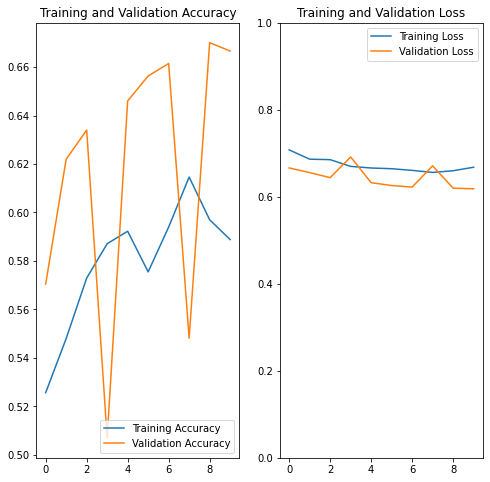

In [119]:
# fig1 = plt.gcf()
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.axis(ymin=0.4,ymax=1)
# plt.grid()
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epochs')
# plt.legend(['train', 'validation'])
# plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
ax = plt.gca()
ax.set_ylim([0, 1])
plt.show()


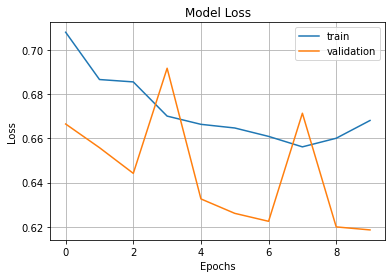

In [120]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.grid()
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epochs')
# plt.legend(['train', 'validation'])
# plt.show()

## Save the model

In [121]:
history.model.save("models/resnet_model.h5")

/Users/Bernardo/opt/anaconda3/envs/vision/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [122]:
# history_dict = history.history

# json.dump(history_dict, open("models/ResNet50.h5", 'w'))

# Conclusion 